# Merton's Jump Diffusion Model (1976)

## Overview
A _jump diffusion model_ is a mixture model combining a diffusion process with a jump process (Figure 1). In finance, jump diffusion models are introduced by Merton [1], who interprets jumps as _“idiosyncratic shocks affecting individual companies but not the market as a whole”_.

#### Figure 1: Sample path of a jump diffusion process
<img src="img/sample-path-jdm.png" alt="Sample Path of a Jump Diffusion Model" style="width: 500px;"/>

### Stochastic Differential Equation
Merton's model specifies the following stochastic differential equation (SDE) for the risky asset:

$$
\frac{dS(t)}{S(t-)}= \mu dt + \sigma dW(t) + dJ(t)
$$

with [2]:

- $S(t-)$ the value of the stock price right before a potential jump, i.e. $S(t-):=\lim_{x\to t-}S(x)$;
- $\mu$, $\sigma$ constant drift and volatility;
- $W$ a one-dimensional standard Brownian motion in $[0,T]$;
- $J$ a __jump process__, independent of $W$, with piecewise constant sample paths.

### The Jump Component
In Merton, $J(t)$ is a _compound Poisson process_ defined by:

$$
J(t) := \sum_{j=1}^{N(t)}(Y_j - 1)
$$

- $N(t)\sim$ Poisson$(\lambda t)$ is a counting process representing the total number of jumps which have occurred up to a certain arrival date $t$;

- $Y(t)$ is a sequence of multiplicative jumps, i.i.d. random variables (independent of both $N$ and $W$), with $Y_j = \frac{S(\tau_j)}{S(\tau_j-)}$, for all $j \in \mathbb{Z} \cap [1, N(t)]$, and $Y_j - 1$ denoting the size of the jump. The latter is positive if a jump occurs at a particular arrival date $t=\tau_j$, and null otherwise, since $S(t) = S(t-)$ and $Y_j = 1$, so that $Y_j - 1 = 1 - 1 = 0$.

### Solution to the SDE
The solution to the SDE is:

$$
S(t) = S_0\exp\bigg\{\bigg(\mu-\frac{1}{2}\sigma^2\bigg)t + \sigma W(t)\bigg\}\bigg(\prod_{j=1}^{N(t)}Y_j\bigg)
$$

When $\prod_{j=1}^{N(t)}Y_j = 1$ (absence of jumps), the equation above is the solution to the _geometric Brownian motion_ SDE.

### Discretisation and Monte Carlo
Discretisation of the solution to the SDE allows to simulate the model using Monte Carlo. The goal of the simulation is to obtain estimates of the expected value and variance for $S(T)$, the stock price at maturity. Such estimates should converge to the theoretical values as the number of simulations increases. Moreover, the probability that the theoretical mean is included in the confidence interval calculated with the Monte Carlo estimates is expected to converge to $1$ as the confidence parameter $\alpha$ decreases, and as the number of experiments grows.

The time interval $[0,T]$ can be subdivided into $\text{Nsteps}+1$ equally-spaced integer monitoring dates $t_j$, with $t_0=0$, $t_{\text{Nsteps}}=T$ and:


$$
t_j := \frac{jT}{\text{Nsteps}}, \quad \forall j \in \mathbb{Z} \cap [0, \text{Nsteps}]
$$


For all integers $j=1,2,\dots, \text{Nsteps}$, the difference $t_{j+1}-t_j$ is constant and equal to:


$$
\Delta t := t_{j+1} - t_j = \frac{T}{\text{Nsteps}}
$$


A discretised version of the solution to Merton's SDE is then given by the following three formulae:


$$
S(t_{j+1}) = S(t_j)\exp\bigg\{\bigg(\mu-\frac{1}{2}\sigma^2\bigg)\Delta t + \sigma Z_1\sqrt{\Delta t} + J\bigg\}, \quad Z_1\sim\mathcal{N}(0,1), \quad \forall t_j \in [0, T]
$$


$$
J = \mu_Y N(\Delta t) + \sigma_Y Z_2\sqrt{N(\Delta t)}, \quad Z_2\sim\mathcal{N}(0,1)
$$


$$
N(\Delta t) \sim \text{Poisson}(\lambda\Delta t)
$$


with $Z_1$ and $Z_2$ two standard Normal random variables independent of each other, $Z_{\ \bullet}\sqrt{\Delta t}$ a discretised version of the standard Brownian motion $W(t)$, and $\mu_Y$ and $\sigma_Y$ the mean and standard deviation of the multiplicative jumps, defined by:

$$
\mu_Y = \mathbb{E}[Y_j] = \exp\bigg\{a + \frac{1}{2}b^2 \bigg\}
$$

$$
\sigma_Y^2 = \text{Var}[Y_j] = \exp\bigg\{2a+b^2\bigg\}\bigg(\exp\big\{b^2\big\}-1\bigg)
$$

with $a$, $b$ such that $\ln(Y_j)\sim\mathcal{N}(a, b^2)$.

### Theoretical Moments 
Closed formulae exist for the expected value and variance at maturity of an asset following Merton's SDE. Under the physical probability measure $\mathbb{P}$:


$$
M = \mathbb{E}^{\mathbb{P}}[S(T)] = S(0)\exp\bigg\{\mu T + \lambda T\big(\mathbb{E}[Y_j]-1\big)\bigg\}
$$


$$
V = \text{Var}^{\mathbb{P}}[S(T)] = S^2(0)\bigg(\exp\bigg\{\big(2\mu+\sigma^2\big)T + \lambda T \big(\mathbb{E}[Y_j^2]-1\big)\bigg\}-\exp\bigg\{2\mu T + 2\lambda T\big(\mathbb{E}[Y_j]-1\big)\bigg\}\bigg)
$$

These exact values can be used to monitor the rate of convergence of Monte Carlo estimates as the number of simulated experiments increases, and can help spot errors, if any, in implementing the model.

## Python Implementation

### Import Required Libraries
A NumPy implementation of Merton's model is included in `jump_diffusion.py`. Here, we go through the code step by step, and start by importing the necessary libraries into Jupyter.

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='viridis')
%matplotlib inline
%config InlineBackend.figure_format='retina'

### Set Random Seed
Then, we set the random seed for reproducibility of the results, and define parameter values.

In [2]:
np.random.seed(0)

### Set Parameter Values
The model parameters are as such:

- `S`: initial price of the risky asset, $S_0$;
- `X`: the strike price, the price at which the risky asset can be either bought (call) or sold (put) in a derivative contract;
- `T`: the maturity of the derivative contract;
- `mu`, `sigma`: respectively, the mean $\mu$ and standard deviation $\sigma$ of the stock price process;
- `Lambda`: the intensity of the Poisson process, $\lambda$ (`lambda` is a protected keyword in Python);
- `a`, `b`: parameters useful to determine $\mu_Y$ and $\sigma^2_Y$;
- `Nsteps`: the number of monitoring dates;
- `Nsim`: the number of simulated experiments;
- `alpha`: significance level required to compute confidence intervals.

In [3]:
S = 1
X = 1.05
T = 1
mu = 0.12
sigma = 0.3
Lambda = 0.25
a = 0.2
b = 0.2
Nsteps = 252
Nsim = 100
alpha = 0.05

### Define Auxiliary Parameters
With the values above, $\Delta t = \frac{T}{\text{Nsteps}}$ is:

In [4]:
Delta_t = T/Nsteps
print('Delta t = {:.6f}'.format(Delta_t))

Delta t = 0.003968


The mean and variance of the multiplicative jumps, $\mu_Y$ and $\sigma^2_Y$, are:

In [5]:
mean_Y = np.exp(a + 0.5*(b**2))
variance_Y = np.exp(2*a + b**2) * (np.exp(b**2)-1)
print('Lognormal mean = {:.6f}'.format(mean_Y))
print('Lognormal variance = {:.6f}'.format(variance_Y))

Lognormal mean = 1.246077
Lognormal variance = 0.063367


### Compute $M$ and $V$
The theoretical mean and variance of the risky asset under Merton's model, $M$ and $V$, are:

In [6]:
M = S * np.exp(mu*T + Lambda*T*(mean_Y-1))
V = S**2 * (np.exp((2*mu + sigma**2)*T + Lambda*T*(variance_Y + mean_Y**2 - 1)) \
            - np.exp(2*mu*T + 2*Lambda*T*(mean_Y - 1)))
print('Theoretical mean = {:.6f}'.format(M))
print('Theoretical variance = {:.6f}'.format(V))

Theoretical mean = 1.199038
Theoretical variance = 0.184891


### Preallocate Memory for the Monte Carlo Experiment
We now preallocate memory for the Monte Carlo simulation by generating a $\text{Nsim} \times (\text{Nsteps+1})$ array of zeros, and populate the first column with the initial asset price (the starting point for every simulated path).

In [7]:
simulated_paths = np.zeros([Nsim, Nsteps+1])
simulated_paths[:,0] = S

The head of the matrix is then:

In [8]:
simulated_paths[:5,:]

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.]])

The memory required to store, respectively, a single array element (standard double precision floating point number) and the whole matrix, are:

In [9]:
print('Size of a single array element: {} bytes'.format(simulated_paths.itemsize))
print('Total memory requirement: {:.2f} kilobytes'.format(simulated_paths.nbytes / 2**10))

Size of a single array element: 8 bytes
Total memory requirement: 197.66 kilobytes


### Generate the Sources of Randomness
We now generate the sources of randomness for the simulation: arrays of i.i.d. standard Normal random variables $Z_1\sim\mathcal{N}(0,1)$ and $Z_2\sim\mathcal{N}(0,1)$, independent of each other, and $N(\Delta t) \sim \text{Poisson}(\lambda\Delta t)$. Jumps will occur whenever a cell value in `Poisson` is different from zero, and both the direction and intensity of the jump will be dictated by the corresponding cell value in `Z_2`.

In [10]:
Z_1 = np.random.normal(size=[Nsim, Nsteps])
Z_2 = np.random.normal(size=[Nsim, Nsteps])
Poisson = np.random.poisson(Lambda*Delta_t, [Nsim, Nsteps])

### Populate the Array
For each row, we populate the remaining columns of the array using the recursion:

In [11]:
for i in range(Nsteps):
    simulated_paths[:,i+1] = simulated_paths[:,i]*np.exp((mu - sigma**2/2)*Delta_t \
                             + sigma*np.sqrt(Delta_t) * Z_1[:,i] + a*Poisson[:,i] \
                             + np.sqrt(b**2) * np.sqrt(Poisson[:,i]) * Z_2[:,i])

The populated matrix, in which each row is a simulated full path for the asset price, and each column a collection of all possible prices at a single monitoring date, looks like this (only the head displayed):

In [12]:
np.set_printoptions(precision=4, suppress=True)
simulated_paths[:5,:]

array([[ 1.    ,  1.0342,  1.0424, ...,  1.2518,  1.2645,  1.2512],
       [ 1.    ,  1.003 ,  0.9972, ...,  0.7351,  0.7507,  0.7477],
       [ 1.    ,  0.9938,  0.9832, ...,  0.5269,  0.5269,  0.5353],
       [ 1.    ,  1.0131,  0.9999, ...,  1.2275,  1.2405,  1.1989],
       [ 1.    ,  0.9994,  1.0042, ...,  1.577 ,  1.56  ,  1.5473]])

### Calculate Monte Carlo Estimate for the Mean and Variance of $S(T)$
The Monte Carlo estimate for the mean of $S(T)$ is then given by the average of all possible values in the end column of the array:

In [13]:
final_prices = simulated_paths[:,-1]
mean_jump = np.mean(final_prices)
var_jump = np.var(final_prices)
print('Monte Carlo estimate for sample mean of S(T) = {:.6f}'.format(mean_jump))
print('Monte Carlo estimate for sample variance of S(T) = {:.6f}'.format(var_jump))

Monte Carlo estimate for sample mean of S(T) = 1.219831
Monte Carlo estimate for sample variance of S(T) = 0.256918


### Compare the Estimates with the Theoretical Values
These value should be compared with the theoretical mean and variance obtained above. With the chosen value of $\text{Nsim}$, the errors of the Monte Carlo estimates, relative to the latter, are:

In [14]:
error_mean = (mean_jump-M) / M
error_variance = (var_jump-V) / V
print('Error of the MC estimate relative to the theoretical mean = {:.2f}%'.format(error_mean * 100))
print('Error of the MC estimate relative to the theoretical variance = {:.2f}%'.format(error_variance * 100))

Error of the MC estimate relative to the theoretical mean = 1.73%
Error of the MC estimate relative to the theoretical variance = 38.96%


### Compute Confidence Intervals for the Mean
The $(1-\alpha)\%$ confidence interval for the true mean is:

In [15]:
std_jump = np.std(final_prices)
ci_low = mean_jump - std_jump/np.sqrt(Nsim)*stats.norm.ppf(1-0.5*alpha)
ci_high = mean_jump + std_jump/np.sqrt(Nsim)*stats.norm.ppf(1-0.5*alpha)
print('{:.0f}% confidence level for the mean: ({:.6f}; {:.6f})'.format((1-alpha)*100, ci_low, ci_high))

95% confidence level for the mean: (1.120487; 1.319176)


This means we can be sure that, $(1-\alpha)\%$ of the times, the computed confidence intervals will contain the true expected value of $S(T)$.

### Graphical Representation

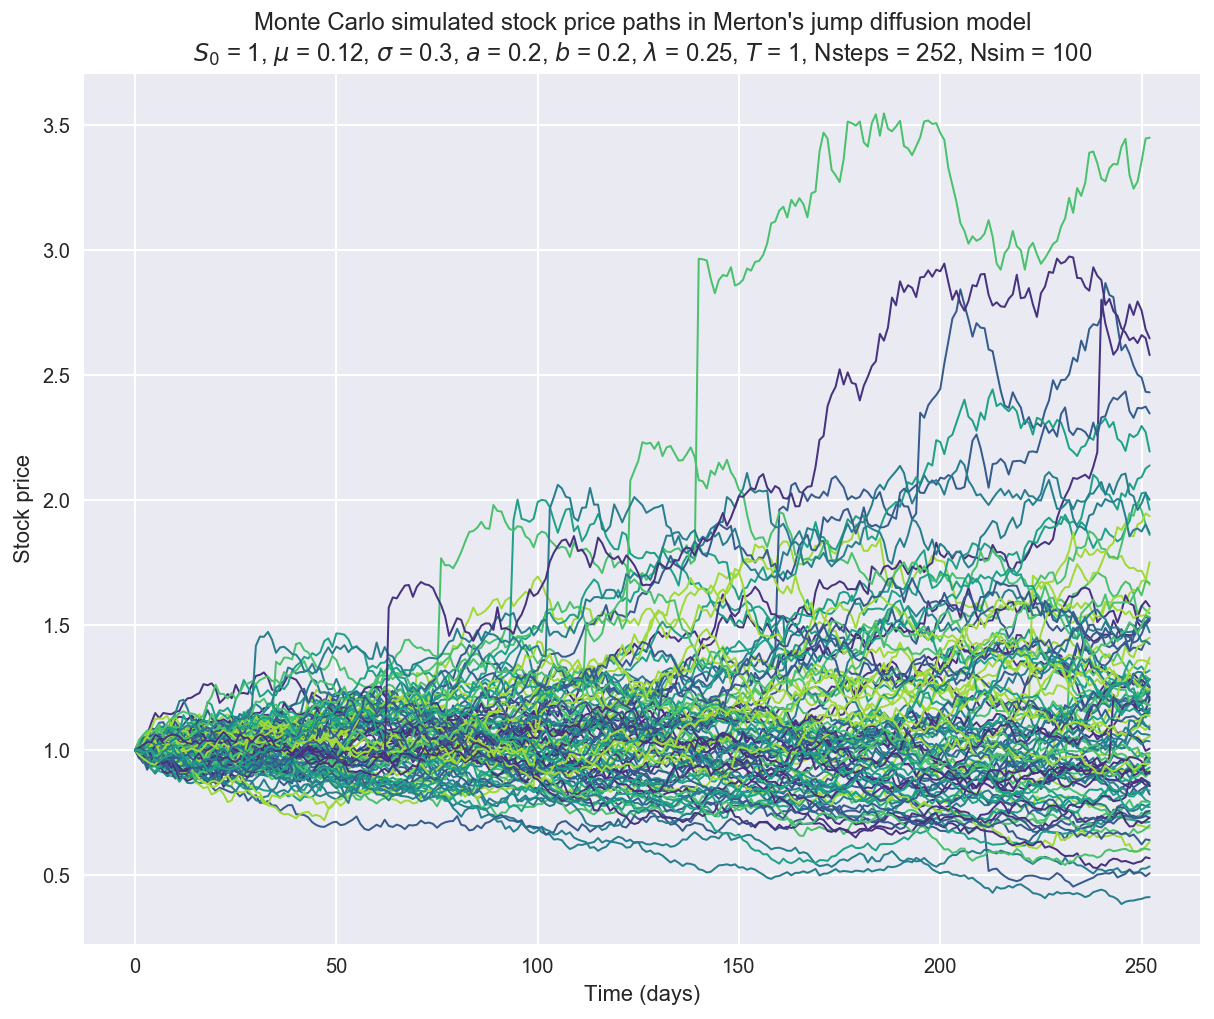

In [16]:
plt.figure(figsize=(10,8))
ax = plt.axes()

t = np.linspace(0, T, Nsteps+1) * Nsteps
jump_diffusion = ax.plot(t, simulated_paths.transpose());

plt.setp(jump_diffusion, linewidth=1);
ax.set(title="Monte Carlo simulated stock price paths in Merton's jump \
diffusion model\n$S_0$ = {}, $\mu$ = {}, $\sigma$ = {}, $a$ = {}, \
$b$ = {}, $\lambda$ = {}, $T$ = {}, Nsteps = {}, Nsim = {}"\
       .format(S, mu, sigma, a, b, Lambda, T, Nsteps, Nsim), \
       xlabel='Time (days)', ylabel='Stock price');

## Bibliography
[1] Merton, R.C. (1976) _Option pricing when underlying stock returns are discontinuous_, Journal of Financial Economics, 3:125-144

[2] Glasserman, P. (2003) _Monte Carlo Methods in Financial Engineering_, Springer Applications of Mathematics, Vol. 53